* Stage 1 - You should submit predicted probabilities for every possible matchup in the past 5 NCAA® tournaments (2015-2019).
    * Due by March 13

* Stage 2 - You should submit predicted probabilities for every possible matchup before the 2021 tournament begins.
    * Due by March 19



In [1]:
import pandas as pd
import numpy as np
import findspark
import re
from functools import reduce
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option("display.max_columns", None)

In [2]:
# I will be using pyspark for data loading and processing

# create entry
spark = SparkSession.builder.appName("MarchMadness").getOrCreate()

def load_dataframe(file_path):
    """read file from relative path."""
    df = spark.read.option('header', True).format('csv').load(file_path)
    return df

In [5]:
# teams data
file_path = '../MarchMadness2021/data/MTeams.csv'
teams = load_dataframe(file_path)
teams.limit(5).toPandas()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2021
1,1102,Air Force,1985,2021
2,1103,Akron,1985,2021
3,1104,Alabama,1985,2021
4,1105,Alabama A&M,2000,2021


### Questions about Teams data
1. Which teams have been in D1 longest, shortest period of time?
2. Which teams joined in 2021?
3. How has the number of teams in D1 increased year to year?

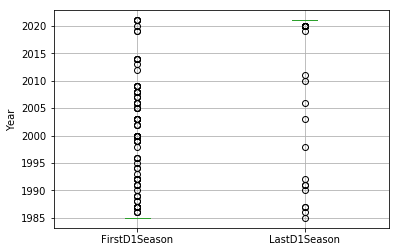

In [38]:
# Lets look at simple plots
teams \
    .select(col('FirstD1Season').cast(IntegerType())
            , col('LastD1Season').cast(IntegerType())) \
    .toPandas().boxplot()
plt.ylabel('Year')
plt.show()

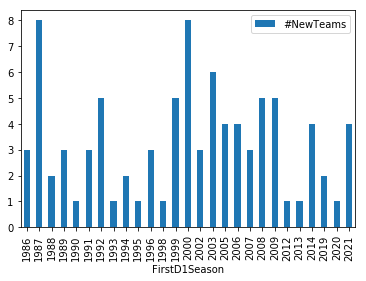

In [52]:
# number of teams each year
teams.groupby('FirstD1Season').count() \
     .withColumnRenamed('count', '#NewTeams') \
     .filter(col('FirstD1Season') != 1985) \
     .orderBy('FirstD1Season') \
     .toPandas().plot('FirstD1Season', '#NewTeams', kind='bar')
plt.show()

* Takeaways
    * D1 league started 1985
    * Lots of teams got into the league in 1985-1995 and not much new entry after 2010.
    * 
    * Total maximum number of years is 37 years including the current year.
* Data is partial and doesn't fully reflect historical data. 

In [41]:
# newbies
teams.filter(col('FirstD1Season') == 2021).toPandas()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1468,Bellarmine,2021,2021
1,1469,Dixie St,2021,2021
2,1470,Tarleton St,2021,2021
3,1471,UC San Diego,2021,2021


In [53]:
# create feature Number of years in D1
teams = teams.withColumn('num_years_D1', 1+col('LastD1Season') - col('FirstD1Season'))

### Questions about Seasons data
* What month did the season start?

In [176]:
# seasons data
file_path = '../MarchMadness2021/data/MSeasons.csv'

seasons = load_dataframe(file_path) \
                .withColumn('DayZero', to_date('DayZero', 'MM/dd/yyyy')) \
                .withColumn('DayZero', to_timestamp(col('DayZero'))) \
                .withColumn('Date', date_format(col('DayZero'), "d MMM")) 
                
seasons.limit(5).toPandas()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ,Date
0,1985,1984-10-29,East,West,Midwest,Southeast,29 Oct
1,1986,1985-10-28,East,Midwest,Southeast,West,28 Oct
2,1987,1986-10-27,East,Southeast,Midwest,West,27 Oct
3,1988,1987-11-02,East,Midwest,Southeast,West,2 Nov
4,1989,1988-10-31,East,West,Midwest,Southeast,31 Oct


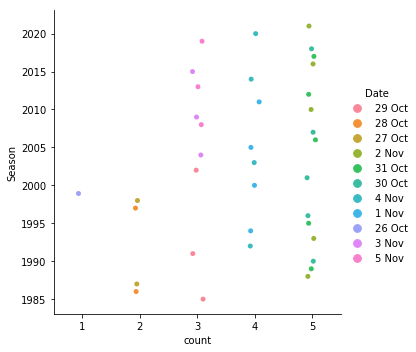

In [177]:
# between 26-November
seasons_df = seasons.groupby('Date').count().join(seasons, on='Date', how='right') \
                   .select(col('Season').cast(IntegerType())
                           , 'Date', col('count').cast(IntegerType())) \
                   .toPandas()


sns.catplot(x='count', y='Season', hue='Date', data=seasons_df)
plt.show()

* Takeaway: late october and first week of november is when college students check out their peers on the court :)

In [162]:
# lets combine these teams and teams dataframes
# seasons.select('Season', 'DayZero', )teams.select('TeamID', 'TeamName', 'num_years_D1')

### Tourney Seeds

In [207]:
# this will be useful to extract each seed of teams 
file_path = '../MarchMadness2021/data/MNCAATourneySeeds.csv'
tourney_seed = load_dataframe(file_path)
tourney_seed.limit(5).toPandas()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


* I have chosen to take a look at the detailed results instead of compact data because of it has more information and includes all of the compact results as well

### Season Detailed Results

In [208]:
file_path = '../MarchMadness2021/data/MRegularSeasonDetailedResults.csv'
detailed_season = load_dataframe(file_path)
detailed_season.limit(5).toPandas()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [246]:
def find_columns(pattern, dataframe):
    df_cols = dataframe.columns
    cols = [column for column in df_cols if re.search(pattern, column)]
    return cols

def check_nulls(df):
    df = df \
    .select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]) \
    .toPandas().T
    if df[df!=0].dropna().empty:
        print('Dataframe has no null values')
    else:
        return df[df[df!=0].dropna()]

In [242]:
# lets create some obvious features and we will explore the data after
detailed_season = detailed_season.withColumn('Win_by', col('WScore') - col('LScore')) \
                                   .withColumn('Loss_by', -1 * col('Win_by'))

# split winning details
win_cols = ['Season'] + find_columns('W', detailed_season)

winner_detailed_season = detailed_season.select(win_cols) \
                                    .withColumn('HomeWin', when(col('WLoc') == 'H', 1).otherwise(0)) \
                                    .withColumn('AwayWin', when(col('WLoc') == 'A', 1).otherwise(0)) \
                                    .withColumn('NeutralWin', when(col('WLoc') == 'N', 1).otherwise(0)) 


# split losing details
loss_cols = ['Season'] + find_columns('L', detailed_season)

loss_detailed_season = detailed_season.select(loss_cols) \
                                    .withColumn('HomeLoss', when(col('WLoc') == 'H', 1).otherwise(0)) \
                                    .withColumn('AwayLoss', when(col('WLoc') == 'A', 1).otherwise(0)) \
                                    .withColumn('NeutralLoss', when(col('WLoc') == 'N', 1).otherwise(0)) 

In [243]:
# lets create winning features
winner_detailed_season = \
    winner_detailed_season.groupby('Season', 'WTeamID') \
        .agg(sum(lit(1)).alias('NumWins'),
             sum(col('HomeWin')).alias('HomeWins'),
             sum(col('AwayWin')).alias('AwayWins'), 
             sum(col('NeutralWin')).alias('NeutralWins'),
             round(sum(col('Win_by')), 1).alias('WinScoreBy'),
             round(sum(when(col('WLoc') == 'H', col('Win_by')).otherwise(0)), 1).alias('WHomeBy'), 
             round(sum(when(col('WLoc') == 'A', col('Win_by')).otherwise(0)), 1).alias('WAwayBy'),
             round(sum(when(col('WLoc') == 'N', col('Win_by')).otherwise(0)), 1).alias('WNeutralBy'),
             round(sum(col('WScore')), 1).alias('WScore'),
             round(sum(when(col('WLoc') == 'H', col('WScore')).otherwise(0)), 1).alias('WHomeScore'),
             round(sum(when(col('WLoc') == 'A', col('WScore')).otherwise(0)), 1).alias('WAwayScore'),
             round(sum(when(col('WLoc') == 'N', col('WScore')).otherwise(0)), 1).alias('WNeutralScore'),
             round(sum(col('WFTA')), 1).alias('WFTA'),
             round(sum(when(col('WLoc') == 'H', col('WFTA')).otherwise(0)), 1).alias('WHomeFTA'), 
             round(sum(when(col('WLoc') == 'A', col('WFTA')).otherwise(0)), 1).alias('WAwayFTA'),
             round(sum(when(col('WLoc') == 'N', col('WFTA')).otherwise(0)), 1).alias('WNeutralFTA'),
             round(sum(col('WFTM')), 1).alias('WFTM'),
             round(sum(when(col('WLoc') == 'H', col('WFTM')).otherwise(0)), 1).alias('WHomeFTM'), 
             round(sum(when(col('WLoc') == 'A', col('WFTM')).otherwise(0)), 1).alias('WAwayFTM'),
             round(sum(when(col('WLoc') == 'N', col('WFTM')).otherwise(0)), 1).alias('WNeutralFTM'),
             round(sum(col('WFGM')), 1).alias('WFGM'),
             round(sum(when(col('WLoc') == 'H', col('WFGM')).otherwise(0)), 1).alias('WHomeFGM'), 
             round(sum(when(col('WLoc') == 'A', col('WFGM')).otherwise(0)), 1).alias('WAwayFGM'),
             round(sum(when(col('WLoc') == 'N', col('WFGM')).otherwise(0)), 1).alias('WNeutralFGM'),
             round(sum(col('WFGA')), 1).alias('WFGA'),
             round(sum(when(col('WLoc') == 'H', col('WFGA')).otherwise(0)), 1).alias('WHomeFGA'), 
             round(sum(when(col('WLoc') == 'A', col('WFGA')).otherwise(0)), 1).alias('WAwayFGA'),
             round(sum(when(col('WLoc') == 'N', col('WFGA')).otherwise(0)), 1).alias('WNeutralFGA'),
             round(sum(col('WFGM3')), 1).alias('WFGM3'),
             round(sum(when(col('WLoc') == 'H', col('WFGM3')).otherwise(0)), 1).alias('WHomeFGM3'), 
             round(sum(when(col('WLoc') == 'A', col('WFGM3')).otherwise(0)), 1).alias('WAwayFGM3'),
             round(sum(when(col('WLoc') == 'N', col('WFGM3')).otherwise(0)), 1).alias('WNeutralFGM3'),
             round(sum(col('WFGA3')), 1).alias('WFGA3'),
             round(sum(when(col('WLoc') == 'H', col('WFGA3')).otherwise(0)), 1).alias('WHomeFGA3'), 
             round(sum(when(col('WLoc') == 'A', col('WFGA3')).otherwise(0)), 1).alias('WAwayFGA3'),
             round(sum(when(col('WLoc') == 'N', col('WFGA3')).otherwise(0)), 1).alias('WNeutralFGA3'),
             round(sum(col('WOR')), 1).alias('WOR'),
             round(sum(when(col('WLoc') == 'H', col('WOR')).otherwise(0)), 1).alias('WHomeOR'), 
             round(sum(when(col('WLoc') == 'A', col('WOR')).otherwise(0)), 1).alias('WAwayOR'),
             round(sum(when(col('WLoc') == 'N', col('WOR')).otherwise(0)), 1).alias('WNeutralOR'),
             round(sum(col('WDR')), 1).alias('WDR'),
             round(sum(when(col('WLoc') == 'H', col('WDR')).otherwise(0)), 1).alias('WHomeDR'), 
             round(sum(when(col('WLoc') == 'A', col('WDR')).otherwise(0)), 1).alias('WAwayDR'),
             round(sum(when(col('WLoc') == 'N', col('WDR')).otherwise(0)), 1).alias('WNeutralDR'),
             round(sum(col('WAst')), 1).alias('WAst'),
             round(sum(when(col('WLoc') == 'H', col('WAst')).otherwise(0)), 1).alias('WHomeAst'), 
             round(sum(when(col('WLoc') == 'A', col('WAst')).otherwise(0)), 1).alias('WAwayAst'),
             round(sum(when(col('WLoc') == 'N', col('WAst')).otherwise(0)), 1).alias('WNeutralAst'),
             round(sum(col('WTO')), 1).alias('WTO'),
             round(sum(when(col('WLoc') == 'H', col('WTO')).otherwise(0)), 1).alias('WHomeTO'), 
             round(sum(when(col('WLoc') == 'A', col('WTO')).otherwise(0)), 1).alias('WAwayTO'),
             round(sum(when(col('WLoc') == 'N', col('WTO')).otherwise(0)), 1).alias('WNeutralTO'),
             round(sum(col('WBlk')), 1).alias('WBlk'),
             round(sum(when(col('WLoc') == 'H', col('WBlk')).otherwise(0)), 1).alias('WHomeBlk'), 
             round(sum(when(col('WLoc') == 'A', col('WBlk')).otherwise(0)), 1).alias('WAwayBlk'),
             round(sum(when(col('WLoc') == 'N', col('WBlk')).otherwise(0)), 1).alias('WNeutralBlk'),
             round(sum(col('WPF')), 1).alias('WPF'),
             round(sum(when(col('WLoc') == 'H', col('WPF')).otherwise(0)), 1).alias('WHomePF'), 
             round(sum(when(col('WLoc') == 'A', col('WPF')).otherwise(0)), 1).alias('WAwayPF'),
             round(sum(when(col('WLoc') == 'N', col('WPF')).otherwise(0)), 1).alias('WNeutralPF'),
             ) \
        .withColumnRenamed('WTeamID', 'TeamID')

# lets check if there are null values
check_nulls(winner_detailed_season)

Dataframe has no null values


In [244]:
# create loss features
loss_detailed_season = \
loss_detailed_season.groupby('Season', 'LTeamID') \
        .agg(sum(lit(1)).alias('NumLoss'),
             sum(col('HomeLoss')).alias('LossHome'),
             sum(col('AwayLoss')).alias('LossAway'), 
             sum(col('NeutralLoss')).alias('LossNeutral'),
             round(sum(col('Loss_by')), 1).alias('LossScoreBy'),
             round(sum(when(col('WLoc') == 'H',  col('Loss_by')).otherwise(0)), 1).alias('LHomeBy'), 
             round(sum(when(col('WLoc') == 'A', col('Loss_by')).otherwise(0)), 1).alias('LAwayBy'),
             round(sum(when(col('WLoc') == 'N', col('Loss_by')).otherwise(0)), 1).alias('LNeutralBy'),
             round(sum(col('LScore')), 1).alias('LScore'),
             round(sum(when(col('WLoc') == 'H', col('LScore')).otherwise(0)), 1).alias('LAwayScore'),
             round(sum(when(col('WLoc') == 'A', col('LScore')).otherwise(0)), 1).alias('LHomeScore'),
             round(sum(when(col('WLoc') == 'N', col('LScore')).otherwise(0)), 1).alias('LNeutralScore'),                             
             round(sum(col('LFTA')), 1).alias('LFTA'),
             round(sum(when(col('WLoc') == 'H', col('LFTA')).otherwise(0)), 1).alias('LAwayFTA'), 
             round(sum(when(col('WLoc') == 'A', col('LFTA')).otherwise(0)), 1).alias('LHomeFTA'),
             round(sum(when(col('WLoc') == 'N', col('LFTA')).otherwise(0)), 1).alias('LNeutralFTA'),
             round(sum(col('LFGM')), 1).alias('LFGM'),
             round(sum(when(col('WLoc') == 'H', col('LFGM')).otherwise(0)), 1).alias('LHomeFGM'), 
             round(sum(when(col('WLoc') == 'A', col('LFGM')).otherwise(0)), 1).alias('LAwayFGM'),
             round(sum(when(col('WLoc') == 'N', col('LFGM')).otherwise(0)), 1).alias('LNeutralFGM'),
             round(sum(col('LFGA')), 1).alias('LFGA'),
             round(sum(when(col('WLoc') == 'H', col('LFGA')).otherwise(0)), 1).alias('LHomeFGA'), 
             round(sum(when(col('WLoc') == 'A', col('LFGA')).otherwise(0)), 1).alias('LAwayFGA'),
             round(sum(when(col('WLoc') == 'N', col('LFGA')).otherwise(0)), 1).alias('LNeutralFGA'),
             round(sum(col('LFGM3')), 1).alias('LFGM3'),
             round(sum(when(col('WLoc') == 'H', col('LFGM3')).otherwise(0)), 1).alias('LHomeFGM3'), 
             round(sum(when(col('WLoc') == 'A', col('LFGM3')).otherwise(0)), 1).alias('LAwayFGM3'),
             round(sum(when(col('WLoc') == 'N', col('LFGM3')).otherwise(0)), 1).alias('LNeutralFGM3'),
             round(sum(col('LFGA3')), 1).alias('LFGA3'),
             round(sum(when(col('WLoc') == 'H', col('LFGA3')).otherwise(0)), 1).alias('LHomeFGA3'), 
             round(sum(when(col('WLoc') == 'A', col('LFGA3')).otherwise(0)), 1).alias('LAwayFGA3'),
             round(sum(when(col('WLoc') == 'N', col('LFGA3')).otherwise(0)), 1).alias('LNeutralFGA3'),
             round(sum(col('LFTM')), 1).alias('LFTM'),
             round(sum(when(col('WLoc') == 'H', col('LFTM')).otherwise(0)), 1).alias('LAwayFTM'), 
             round(sum(when(col('WLoc') == 'A', col('LFTM')).otherwise(0)), 1).alias('LHomeFTM'),
             round(sum(when(col('WLoc') == 'N', col('LFTM')).otherwise(0)), 1).alias('LNeutralFTM'),
             round(sum(col('LOR')), 1).alias('LOR'),
             round(sum(when(col('WLoc') == 'H', col('LOR')).otherwise(0)), 1).alias('LAwayOR'), 
             round(sum(when(col('WLoc') == 'A', col('LOR')).otherwise(0)), 1).alias('LHomeOR'),
             round(sum(when(col('WLoc') == 'N', col('LOR')).otherwise(0)), 1).alias('LNeutralOR'),
             round(sum(col('LDR')), 1).alias('LDR'),
             round(sum(when(col('WLoc') == 'H', col('LDR')).otherwise(0)), 1).alias('LAwayDR'), 
             round(sum(when(col('WLoc') == 'A', col('LDR')).otherwise(0)), 1).alias('LHomeDR'),
             round(sum(when(col('WLoc') == 'N', col('LDR')).otherwise(0)), 1).alias('LNeutralDR'),
             round(sum(col('LAst')), 1).alias('LAst'),
             round(sum(when(col('WLoc') == 'H', col('LAst')).otherwise(0)), 1).alias('LAwayAst'), 
             round(sum(when(col('WLoc') == 'A', col('LAst')).otherwise(0)), 1).alias('LHomeAst'),
             round(sum(when(col('WLoc') == 'N', col('LAst')).otherwise(0)), 1).alias('LNeutralAst'),
             round(sum(col('LTO')), 1).alias('LTO'),
             round(sum(when(col('WLoc') == 'H', col('LTO')).otherwise(0)), 1).alias('LAwayTO'), 
             round(sum(when(col('WLoc') == 'A', col('LTO')).otherwise(0)), 1).alias('LHomeTO'),
             round(sum(when(col('WLoc') == 'N', col('LTO')).otherwise(0)), 1).alias('LNeutralTO'),
             round(sum(col('LBlk')), 1).alias('LBlk'),
             round(sum(when(col('WLoc') == 'H', col('LBlk')).otherwise(0)), 1).alias('LAwayBlk'), 
             round(sum(when(col('WLoc') == 'A', col('LBlk')).otherwise(0)), 1).alias('LHomeBlk'),
             round(sum(when(col('WLoc') == 'N', col('LBlk')).otherwise(0)), 1).alias('LNeutralBlk'),
             round(sum(col('LPF')), 1).alias('LPF'),
             round(sum(when(col('WLoc') == 'H', col('LPF')).otherwise(0)), 1).alias('LAwayPF'), 
             round(sum(when(col('WLoc') == 'A', col('LPF')).otherwise(0)), 1).alias('LHomePF'),
             round(sum(when(col('WLoc') == 'N', col('LPF')).otherwise(0)), 1).alias('LNeutralPF'),
             ) \
        .withColumnRenamed('LTeamID', 'TeamID')

check_nulls(loss_detailed_season)


In [249]:
#lets aggregate them (good luck reading this)..yeyeye i could probably use udfs to simplify this. 
detailed_season_agg = winner_detailed_season\
.join(loss_detailed_season, ['Season', 'TeamID'], 'inner') \
.withColumn('NumTotal', col('NumWins') + col('NumLoss')) \
.withColumn('Score', round((col('WScore') + col('LScore'))/col('NumTotal'), 2)) \
.withColumn('HomeScore', round((col('WHomeScore') + col('LHomeScore'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayScore', round((col('WAwayScore') + col('LAwayScore'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralScore', round((col('WNeutralScore') + col('LNeutralScore'))/(col('NeutralWins') + col('LossNeutral')), 2)) \
.withColumn('ScoreBy', round((col('WinScoreBy') + col('LossScoreBy'))/col('NumTotal'), 2)) \
.withColumn('HomeBy', round((col('WHomeBy') + col('LHomeBy'))/col('NumTotal'), 2)) \
.withColumn('AwayBy', round((col('WAwayBy') + col('LAwayBy'))/col('NumTotal'), 2)) \
.withColumn('NeutralBy', round((col('WNeutralBy') + col('LNeutralBy'))/col('NumTotal'), 2)) \
.withColumn('Pct', round(100*col('NumWins')/col('NumTotal'), 2)) \
.withColumn('HomePct', round(100*col('HomeWins')/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayPct', round(100*col('AwayWins')/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralPct', round(100*col('NeutralWins')/(col('NeutralWins') + col('LossNeutral')), 2)) \
.withColumn('FG', round(100 * (col('LFGM') + col('WFGM'))/(col('LFGA') + col('WFGA')), 2)) \
.withColumn('HomeFG', round(100 * (col('LHomeFGM') + col('WHomeFGM'))/(col('LHomeFGA') + col('WHomeFGA')), 2)) \
.withColumn('AwayFG', round(100 * (col('LAwayFGM') + col('WAwayFGM'))/(col('LAwayFGA') + col('WAwayFGA')), 2)) \
.withColumn('NeutralFG', round(100 * (col('LNeutralFGM') + col('WNeutralFGM'))/(col('LNeutralFGA') + col('WNeutralFGA')), 2)) \
.withColumn('FG3', round(100 * (col('LFGM3') + col('WFGM3'))/(col('LFGA3') + col('WFGA3')), 2)) \
.withColumn('HomeFG3', round(100 * (col('LHomeFGM3') + col('WHomeFGM3'))/(col('LHomeFGA3') + col('WHomeFGA3')), 2)) \
.withColumn('AwayFG3', round(100 * (col('LAwayFGM3') + col('WAwayFGM3'))/(col('LAwayFGA3') + col('WAwayFGA3')), 2)) \
.withColumn('NeutralFG3', round(100 * (col('LNeutralFGM3') + col('WNeutralFGM3'))/(col('LNeutralFGA3') + col('WNeutralFGA3')), 2)) \
.withColumn('FT', round(100*(col('LFTM') + col('WFTM'))/(col('LFTA') + col('WFTA')), 2)) \
.withColumn('HomeFT', round(100*(col('LHomeFTM') + col('WHomeFTM'))/(col('LHomeFTA') + col('WHomeFTA')), 2)) \
.withColumn('AwayFT', round(100*(col('LAwayFTM') + col('WAwayFTM'))/(col('LAwayFTA') + col('WAwayFTA')), 2)) \
.withColumn('NeutralFT', round(100*(col('LNeutralFTM') + col('WNeutralFTM'))/(col('LNeutralFTA') + col('WNeutralFTA')), 2)) \
.withColumn('OR', round((col('LOR') + col('WOR'))/col('NumTotal'), 2)) \
.withColumn('HomeOR', round((col('LHomeOR') + col('WHomeOR'))/col('NumTotal'), 2)) \
.withColumn('AwayOR', round((col('LAwayOR') + col('WAwayOR'))/col('NumTotal'), 2)) \
.withColumn('NeutralOR', round((col('LNeutralOR') + col('WNeutralOR'))/col('NumTotal'), 2)) \
.withColumn('DR', round((col('LDR') + col('WDR'))/col('NumTotal'), 2)) \
.withColumn('HomeDR', round((col('LHomeDR') + col('WHomeDR'))/col('NumTotal'), 2)) \
.withColumn('AwayDR', round((col('LAwayDR') + col('WAwayDR'))/col('NumTotal'), 2)) \
.withColumn('NeutralDR', round((col('LNeutralDR') + col('WNeutralDR'))/col('NumTotal'), 2)) \
.withColumn('DR/OR', round((col('LDR') + col('WDR'))/(col('LOR') + col('WOR')), 2)) \
.withColumn('HomeDR/OR', round((col('LHomeDR') + col('WHomeDR'))/(col('LHomeOR') + col('WHomeOR')), 2)) \
.withColumn('AwayDR/OR', round((col('LAwayDR') + col('WAwayDR'))/(col('LAwayOR') + col('WAwayOR')), 2)) \
.withColumn('NeutralDR/OR', round((col('LNeutralDR') + col('WNeutralDR'))/(col('LNeutralOR') + col('WNeutralOR')), 2)) \
.withColumn('Ast', round((col('LAst') + col('WAst'))/col('NumTotal'), 2)) \
.withColumn('HomeAst', round((col('LHomeAst') + col('WHomeAst'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayAst', round((col('LAwayAst') + col('WAwayAst'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralAst', round((col('LNeutralAst') + col('WNeutralAst'))/(col('NeutralWins') + col('LossNeutral')), 2)) \
.withColumn('TO', round((col('LTO') + col('WTO'))/col('NumTotal'), 2)) \
.withColumn('HomeTO', round((col('LHomeTO') + col('WHomeTO'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayTO', round((col('LAwayTO') + col('WAwayTO'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralTO', round((col('LNeutralTO') + col('WNeutralTO'))/(col('NeutralWins') + col('LossNeutral')), 1)) \
.withColumn('Ast/TO', round((col('LAst') + col('WAst'))/(col('LTO') + col('WTO')), 2)) \
.withColumn('Blk', round((col('LBlk') + col('WBlk'))/col('NumTotal'), 2)) \
.withColumn('HomeBlk', round((col('LHomeBlk') + col('WHomeBlk'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayBlk', round((col('LAwayBlk') + col('WAwayBlk'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralBlk', round((col('LNeutralBlk') + col('WNeutralBlk'))/(col('NeutralWins') + col('LossNeutral')), 2)) \
.withColumn('PF', round((col('LPF') + col('WPF'))/col('NumTotal'), 2)) \
.withColumn('HomePF', round((col('LHomePF') + col('WHomePF'))/(col('HomeWins') + col('LossHome')), 2)) \
.withColumn('AwayPF', round((col('LAwayPF') + col('WAwayPF'))/(col('AwayWins') + col('LossAway')), 2)) \
.withColumn('NeutralPF', round((col('LNeutralPF') + col('WNeutralPF'))/(col('NeutralWins') + col('LossNeutral')), 2)) \
.drop('NumWins', 'NumLoss','LossHome', 'LossAway', 'LossNeutral', 'WinScoreBy', 'LossScoreBy'
      , 'WHomeScore', 'LHomeScore', 'WHomeBy', 'LHomeBy', 'WAwayScore', 'LAwayScore', 'WNeutralScore'
      , 'LNeutralScore', 'WAwayBy', 'LAwayBy', 'WNeutralBy', 'LNeutralBy', 'WScore', 'LScore'
      , 'HomeWins', 'AwayWins', 'NeutralWins', 'LFGM', 'WFGM', 'LFGM3', 'WFGM3'
      , 'LFGA', 'WFGA','LHomeFGM','WHomeFGM', 'LHomeFGA', 'WHomeFGA','LAwayFGM'
      , 'WAwayFGM', 'LAwayFGA', 'WAwayFGA', 'LNeutralFGM', 'WNeutralFGM', 'LNeutralFGA'
      ,  'WNeutralFGA', 'LFGM3', 'WFGA3', 'LFGA3', 'LFTA', 'WFTA','LFTM', 'WFTM', 'LHomeFTM' 
      , 'WHomeFTM', 'LHomeFTA', 'WHomeFTA', 'LAwayFTM', 'WAwayFTM', 'LAwayFTA', 'WAwayFTA'
      , 'LNeutralFTM', 'WNeutralFTM', 'LNeutralFTA', 'WNeutralFTA','LOR' ,'LHomeFGM3'
      ,'WHomeFGM3', 'LHomeFGA3', 'WHomeFGA3','LAwayFGM3', 'WAwayFGM3', 'LAwayFGA3'
      , 'WAwayFGA3', 'LNeutralFGM3', 'WNeutralFGM3', 'LNeutralFGA3', 'WNeutralFGA3'
      , 'WOR', 'LDR', 'WDR', 'LHomeDR', 'WHomeDR', 'LAwayDR', 'WAwayDR', 'LNeutralDR'
      , 'WNeutralDR', 'LHomeDR', 'WHomeDR','LAwayDR', 'WAwayDR', 'LNeutralDR', 'WNeutralDR' 
      , 'LOR', 'WOR', 'LHomeOR', 'WHomeOR', 'LAwayOR', 'WAwayOR', 'LNeutralOR', 'WNeutralOR'
      , 'LAst', 'WAst', 'WHomeAst', 'WAwayAst', 'WNeutralAst', 'LAwayAst', 'LHomeAst', 'LNeutralAst'
      , 'LTO', 'WTO', 'WHomeTO', 'WAwayTO', 'WNeutralTO', 'LAwayTO', 'LHomeTO', 'LNeutralTO'
      , 'LBlk', 'WBlk', 'WHomeBlk', 'WAwayBlk', 'WNeutralBlk', 'LAwayBlk', 'LHomeBlk', 'LNeutralBlk'
      , 'LPF', 'WPF', 'WHomePF', 'WAwayPF', 'WNeutralPF', 'LAwayPF', 'LHomePF', 'LNeutralPF')

In [252]:
# perhaps would be helpful if we knew the name of the teams for lookup and checking purposes
# 
teams.select('TeamName', 'TeamID', 'num_years_D1') \
     .join(detailed_season_agg, on=['TeamID'], how='inner').limit(5).toPandas()

,TeamID,TeamName,num_years_D1,Season,NumTotal,Score,HomeScore,AwayScore,NeutralScore,ScoreBy,HomeBy,AwayBy,NeutralBy,Pct,HomePct,AwayPct,NeutralPct,FG,HomeFG,AwayFG,NeutralFG,FG3,HomeFG3,AwayFG3,NeutralFG3,FT,HomeFT,AwayFT,NeutralFT,OR,HomeOR,AwayOR,NeutralOR,DR,HomeDR,AwayDR,NeutralDR,DR/OR,HomeDR/OR,AwayDR/OR,NeutralDR/OR,Ast,HomeAst,AwayAst,NeutralAst,TO,HomeTO,AwayTO,NeutralTO,Ast/TO,Blk,HomeBlk,AwayBlk,NeutralBlk,PF,HomePF,AwayPF,NeutralPF
0,1308,New Mexico St,37.0,2003,28,73.11,56.76,110.13,67.00,5.61,2.89,2.36,0.36,67.86,64.71,75.0,66.67,44.75,43.97,47.61,41.92,34.68,31.25,40.43,39.02,73.75,74.16,72.65,76.27,12.32,5.64,5.71,0.96,23.57,11.07,9.71,2.79,1.91,1.96,1.70,2.89,12.46,10.12,17.13,13.33,13.43,9.59,21.75,13.0,0.93,4.04,3.24,6.5,2.0,16.36,11.47,27.88,13.33
1,1330,Old Dominion,37.0,2003,27,66.63,60.69,77.60,52.00,2.04,1.85,0.52,-0.33,44.44,50.00,40.0,0.00,40.22,40.29,40.72,33.33,31.92,30.42,34.74,26.32,70.24,68.42,74.67,50.00,13.96,7.56,5.96,0.44,23.85,13.00,9.93,0.93,1.71,1.72,1.66,2.08,14.22,14.38,14.30,11.00,13.30,11.00,17.10,12.0,1.07,2.78,3.06,2.3,3.0,18.33,15.38,22.60,23.00
2,1119,Army,37.0,2003,25,53.68,44.00,68.60,40.00,-13.80,-9.28,-3.80,-0.72,12.00,14.29,10.0,0.00,41.18,39.91,43.40,36.59,35.59,33.19,40.00,26.67,67.61,67.69,68.36,54.55,7.92,3.64,4.16,0.12,21.56,9.08,11.48,1.00,2.72,2.49,2.76,8.33,11.72,9.29,15.00,13.00,17.36,13.00,23.50,17.0,0.68,1.60,1.07,2.1,4.0,19.32,14.93,25.70,17.00
3,1186,E Washington,37.0,2005,27,61.41,35.82,114.00,68.50,-6.26,-4.96,-1.00,-0.30,25.93,23.53,25.0,50.00,41.91,41.55,40.67,51.09,33.27,32.02,32.59,47.22,66.04,61.58,70.20,61.90,9.37,4.00,4.70,0.67,21.41,8.37,11.78,1.26,2.28,2.09,2.50,1.89,13.67,8.00,25.13,16.00,16.26,8.76,33.13,12.5,0.84,1.70,1.29,3.0,0.0,20.85,11.59,40.75,20.00
4,1216,Hartford,37.0,2005,28,59.46,39.00,138.20,64.67,-10.32,-6.79,-2.79,-0.75,28.57,35.00,0.0,33.33,39.15,39.59,35.16,43.35,28.79,30.16,22.73,31.11,62.94,70.00,56.61,60.00,12.75,5.50,6.11,1.14,21.50,9.61,9.39,2.50,1.69,1.75,1.54,2.19,8.96,5.55,21.20,11.33,14.61,8.05,40.20,15.7,0.61,1.93,1.30,5.0,1.0,21.07,12.20,58.20,18.33


In [253]:
winner_detailed_season.filter(col('Season') == 2003).filter(col('TeamID') == 1308).toPandas()

,Season,TeamID,NumWins,HomeWins,AwayWins,NeutralWins,WinScoreBy,WHomeBy,WAwayBy,WNeutralBy,WScore,WHomeScore,WAwayScore,WNeutralScore,WFTA,WHomeFTA,WAwayFTA,WNeutralFTA,WFTM,WHomeFTM,WAwayFTM,WNeutralFTM,WFGM,WHomeFGM,WAwayFGM,WNeutralFGM,WFGA,WHomeFGA,WAwayFGA,WNeutralFGA,WFGM3,WHomeFGM3,WAwayFGM3,WNeutralFGM3,WFGA3,WHomeFGA3,WAwayFGA3,WNeutralFGA3,WOR,WHomeOR,WAwayOR,WNeutralOR,WDR,WHomeDR,WAwayDR,WNeutralDR,WAst,WHomeAst,WAwayAst,WNeutralAst,WTO,WHomeTO,WAwayTO,WNeutralTO,WBlk,WHomeBlk,WAwayBlk,WNeutralBlk,WPF,WHomePF,WAwayPF,WNeutralPF
0,2003,1308,19,11,6,2,232.0,133.0,79.0,20.0,1449.0,839.0,470.0,140.0,397.0,243.0,114.0,40.0,302.0,186.0,86.0,30.0,513.0,295.0,169.0,49.0,1087.0,639.0,334.0,114.0,121.0,63.0,46.0,12.0,317.0,186.0,101.0,30.0,224.0,132.0,71.0,21.0,474.0,264.0,154.0,56.0,262.0,150.0,84.0,28.0,252.0,139.0,87.0,26.0,77.0,47.0,26.0,4.0,290.0,163.0,99.0,28.0


In [254]:
loss_detailed_season.filter(col('Season') == 2003).filter(col('TeamID') == 1308).toPandas()

,Season,TeamID,NumLoss,LossHome,LossAway,LossNeutral,LossScoreBy,LHomeBy,LAwayBy,LNeutralBy,LScore,LAwayScore,LHomeScore,LNeutralScore,LFTA,LAwayFTA,LHomeFTA,LNeutralFTA,LFGM,LHomeFGM,LAwayFGM,LNeutralFGM,LFGA,LHomeFGA,LAwayFGA,LNeutralFGA,LFGM3,LHomeFGM3,LAwayFGM3,LNeutralFGM3,LFGA3,LHomeFGA3,LAwayFGA3,LNeutralFGA3,LFTM,LAwayFTM,LHomeFTM,LNeutralFTM,LOR,LAwayOR,LHomeOR,LNeutralOR,LDR,LAwayDR,LHomeDR,LNeutralDR,LAst,LAwayAst,LHomeAst,LNeutralAst,LTO,LAwayTO,LHomeTO,LNeutralTO,LBlk,LAwayBlk,LHomeBlk,LNeutralBlk,LPF,LAwayPF,LHomePF,LNeutralPF
0,2003,1308,9,6,2,1,-75.0,-52.0,-13.0,-10.0,598.0,411.0,126.0,61.0,205.0,131.0,55.0,19.0,207.0,146.0,40.0,21.0,522.0,364.0,105.0,53.0,42.0,27.0,11.0,4.0,153.0,102.0,40.0,11.0,142.0,92.0,35.0,15.0,121.0,89.0,26.0,6.0,186.0,118.0,46.0,22.0,87.0,53.0,22.0,12.0,124.0,87.0,24.0,13.0,36.0,26.0,8.0,2.0,168.0,124.0,32.0,12.0
